In [1]:
import pandas as pd
import os
import calendar

#Takes in data from an online source. The online source has 12 csv files for each month of sales data. 
#The loop reads each csv and saves the data in a new folder
base_url = 'https://raw.githubusercontent.com/KeithGalli/Pandas-Data-Science-Tasks/master/SalesAnalysis/Sales_Data'
for month in range(12):
    new_csv = pd.read_csv(base_url + f'/Sales_{calendar.month_name[month+1]}_2019.csv')
    new_csv.to_csv(f'Excel_Downloads/{calendar.month_name[month+1]}_Sales_Data_2019.csv', index=False)
print('Data successfully downloaded!')

Data successfully downloaded!


In [2]:
#Used to read all the csv files from a directory and create a dataframe to concatenate the monthly sales data
#into one yearly sales csv
list_files = [file for file in os.listdir('Excel_Downloads')]
yearly_data = pd.DataFrame()
for file in list_files:
    one_file = pd.read_csv('Excel_Downloads/'+file)
    yearly_data = pd.concat([yearly_data, one_file])
print('Data successfully loaded into the dataframe!')

Data successfully loaded into the dataframe!


In [3]:
#all the cleaning and type conversions done with the yearly sales data dataframe
#drops all the null values, converts the date column into a pandas datetime object and reformats it to string for Azure data lake
#converts the relevant columns to numeric type
#creates a column to calculate total sale amount
#extracts the state and city from the address column and creates a new column for each one
yearly_data = yearly_data.dropna(how="all")
yearly_data = yearly_data[yearly_data['Order Date'].str[0:2] != 'Or']
yearly_data['Order Date'] = pd.to_datetime(yearly_data['Order Date'])
yearly_data['Order Date'] = yearly_data['Order Date'].dt.strftime('%m-%d-%Y %H:%M')
yearly_data['Quantity Ordered'] = pd.to_numeric(yearly_data['Quantity Ordered'])
yearly_data['Price Each'] = pd.to_numeric(yearly_data['Price Each'])
yearly_data['Sale Amount'] = yearly_data['Quantity Ordered'] * yearly_data['Price Each']
yearly_data['State'] = yearly_data['Purchase Address'].apply(lambda x: x.split(',')[2].split(" ")[1])
yearly_data['City'] = yearly_data['Purchase Address'].apply(lambda x: x.split(",")[1].strip()) + " (" + yearly_data['State'] + ")"

#saves the transformed yearly data into a new csv
yearly_data.to_csv('Excel_Downloads/yearly_sales_data_2019_cleaned.csv', index=False)

print('Data loaded into combined csv.')

C:\Users\sohai\AppData\Local\Temp\ipykernel_7892\648116708.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  yearly_data['Order Date'] = pd.to_datetime(yearly_data['Order Date'])


Data loaded into combined csv.


In [6]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

#displays a prview of the transformed data with new columns and type conversions
yearly_sales_data = pd.read_csv('Excel_Downloads/yearly_sales_data_2019_cleaned.csv')
print(yearly_sales_data.head(50).to_string())

    Order ID                     Product  Quantity Ordered  Price Each        Order Date                           Purchase Address  Sale Amount State                City
0     176558        USB-C Charging Cable                 2       11.95  04-19-2019 08:46               917 1st St, Dallas, TX 75001        23.90    TX         Dallas (TX)
1     176559  Bose SoundSport Headphones                 1       99.99  04-07-2019 22:30          682 Chestnut St, Boston, MA 02215        99.99    MA         Boston (MA)
2     176560                Google Phone                 1      600.00  04-12-2019 14:38       669 Spruce St, Los Angeles, CA 90001       600.00    CA    Los Angeles (CA)
3     176560            Wired Headphones                 1       11.99  04-12-2019 14:38       669 Spruce St, Los Angeles, CA 90001        11.99    CA    Los Angeles (CA)
4     176561            Wired Headphones                 1       11.99  04-30-2019 09:27          333 8th St, Los Angeles, CA 90001        11.99 

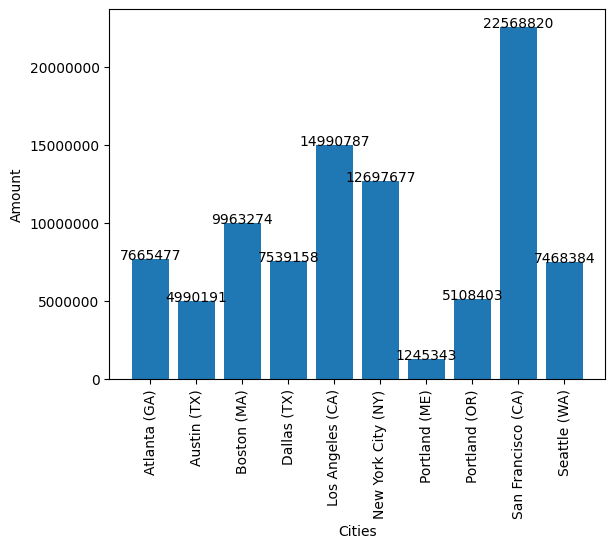

In [12]:
import matplotlib.pyplot as plt

#analysis on the yearly sales data
#shows the total sales within each city, with the exact amount displayed on top of each bar
total_by_city = yearly_sales_data.groupby(yearly_sales_data['City']).sum(numeric_only=True)
cities = total_by_city.index
plt.bar(cities, total_by_city['Sale Amount'])
for index, value in enumerate(total_by_city['Sale Amount']):
    plt.text(x=index, y=value+2, s=f"{value:.0f}", ha = "center")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation='vertical')
plt.xlabel('Cities')
plt.ylabel('Amount')
plt.show()

In [ ]:
from azure.storage.filedatalake import (DataLakeServiceClient, DataLakeDirectoryClient, FileSystemClient)
import os

#a method to upload a file to Azure data lake gen2 using private account credentials
def upload_file_to_directory(directory_client: DataLakeDirectoryClient, local_path: str, file_name: str):
    file_client = directory_client.get_file_client(file_name)

    with open(file=os.path.join(local_path, file_name), mode="rb") as data:
        file_client.upload_data(data, overwrite=True)

#calling the method with private credentials to upload the yearly sales data to a data lake gen2 container
upload_file_to_directory(directory_client=DataLakeDirectoryClient(account_url="<account_url>",
                        credential="<account-key>",
                        file_system_name="project-data-dump", directory_name="project-csv-data"),
                        local_path="Excel_Downloads", file_name="yearly_sales_data_2019_cleaned.csv")

print('Data successfully uploaded.')

In [15]:
#More than 300000 rows uploaded to the datalake container for further analysis in Azure Synapse Analytics
print(yearly_sales_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507872 entries, 0 to 507871
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          507872 non-null  int64  
 1   Product           507872 non-null  object 
 2   Quantity Ordered  507872 non-null  int64  
 3   Price Each        507872 non-null  float64
 4   Order Date        507872 non-null  object 
 5   Purchase Address  507872 non-null  object 
 6   Sale Amount       507872 non-null  float64
 7   State             507872 non-null  object 
 8   City              507872 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 34.9+ MB
None


In [9]:
#a new dataframe that parses the order date column as a pandas datetime object for time-series analysis
yearly_df = pd.read_csv('Excel_Downloads/yearly_sales_data_2019_cleaned.csv', parse_dates=['Order Date'])
print(yearly_df.head().to_string())

   Order ID                     Product  Quantity Ordered  Price Each          Order Date                      Purchase Address  Sale Amount State              City
0    176558        USB-C Charging Cable                 2       11.95 2019-04-19 08:46:00          917 1st St, Dallas, TX 75001        23.90    TX       Dallas (TX)
1    176559  Bose SoundSport Headphones                 1       99.99 2019-04-07 22:30:00     682 Chestnut St, Boston, MA 02215        99.99    MA       Boston (MA)
2    176560                Google Phone                 1      600.00 2019-04-12 14:38:00  669 Spruce St, Los Angeles, CA 90001       600.00    CA  Los Angeles (CA)
3    176560            Wired Headphones                 1       11.99 2019-04-12 14:38:00  669 Spruce St, Los Angeles, CA 90001        11.99    CA  Los Angeles (CA)
4    176561            Wired Headphones                 1       11.99 2019-04-30 09:27:00     333 8th St, Los Angeles, CA 90001        11.99    CA  Los Angeles (CA)


In [6]:
#Groups the data by month to see which month had the highest sales
months = yearly_df['Order Date'].dt.month
total_by_month = yearly_df.groupby(months).sum('Sale Amount')
print(total_by_month)

               Order ID  Quantity Ordered   Price Each  Sale Amount
Order Date                                                         
1            4244009854             32627   5418298.34   5449429.61
2            5613157776             40347   6566654.16   6606067.26
3            7694432868             51015   8373623.49   8421301.14
4           10162041300             61674  10103013.06  10172010.72
5           10037614569             56001   9405375.39   9457820.25
6            8798928216             45759   7686076.83   7733406.78
7            9852418728             48216   7897618.68   7943327.28
8            8698121751             40344   6691036.26   6733403.64
9            8846180493             39327   6254976.27   6292680.39
10          16371331149             68109  11146664.49  11210180.64
11          15141607719             59394   9541802.04   9598809.60
12           7702613907             28182   4594015.13   4619076.36


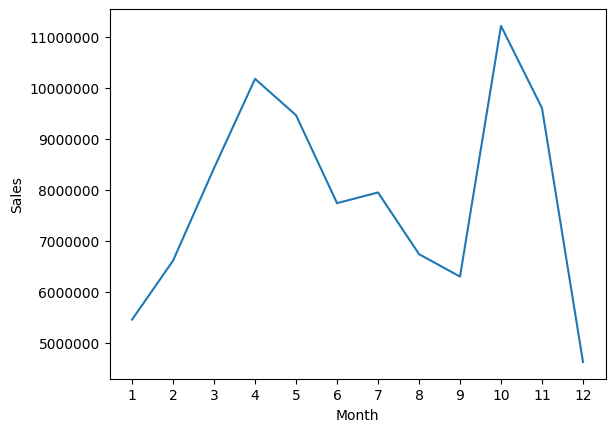

In [8]:
#Line chart to display the change in sales over the year
plt.plot(total_by_month.index, total_by_month['Sale Amount'])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(total_by_month.index)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

In [17]:
#total sale for each product category
product_sum = yearly_df.groupby('Product').sum('Sale Amount')
print(product_sum['Sale Amount'].to_string())

Product
20in Monitor                   1236837.55
27in 4K Gaming Monitor         6633729.90
27in FHD Monitor               3107792.80
34in Ultrawide Monitor         6421451.01
AA Batteries (4-pack)           289800.96
AAA Batteries (4-pack)          252867.29
Apple Airpods Headphones       6423750.00
Bose SoundSport Headphones     3671732.79
Flatscreen TV                  3938100.00
Google Phone                   9098400.00
LG Dryer                       1059600.00
LG Washing Machine             1102800.00
Lightning Charging Cable        948921.35
Macbook Pro Laptop            21923200.00
ThinkPad Laptop               11307886.92
USB-C Charging Cable            781804.85
Vareebadd Phone                2253600.00
Wired Headphones                673538.25
iPhone                        13111700.00


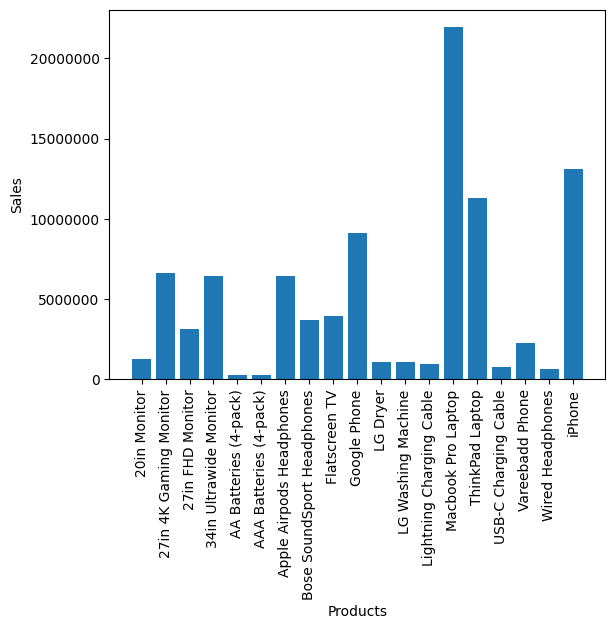

In [18]:
#displays the comparison of sales of each product category
product_sum = yearly_df.groupby('Product').sum('Sale Amount')
plt.bar(product_sum.index, product_sum['Sale Amount'])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation='vertical')
plt.ylabel('Sales')
plt.xlabel('Products')
plt.show()